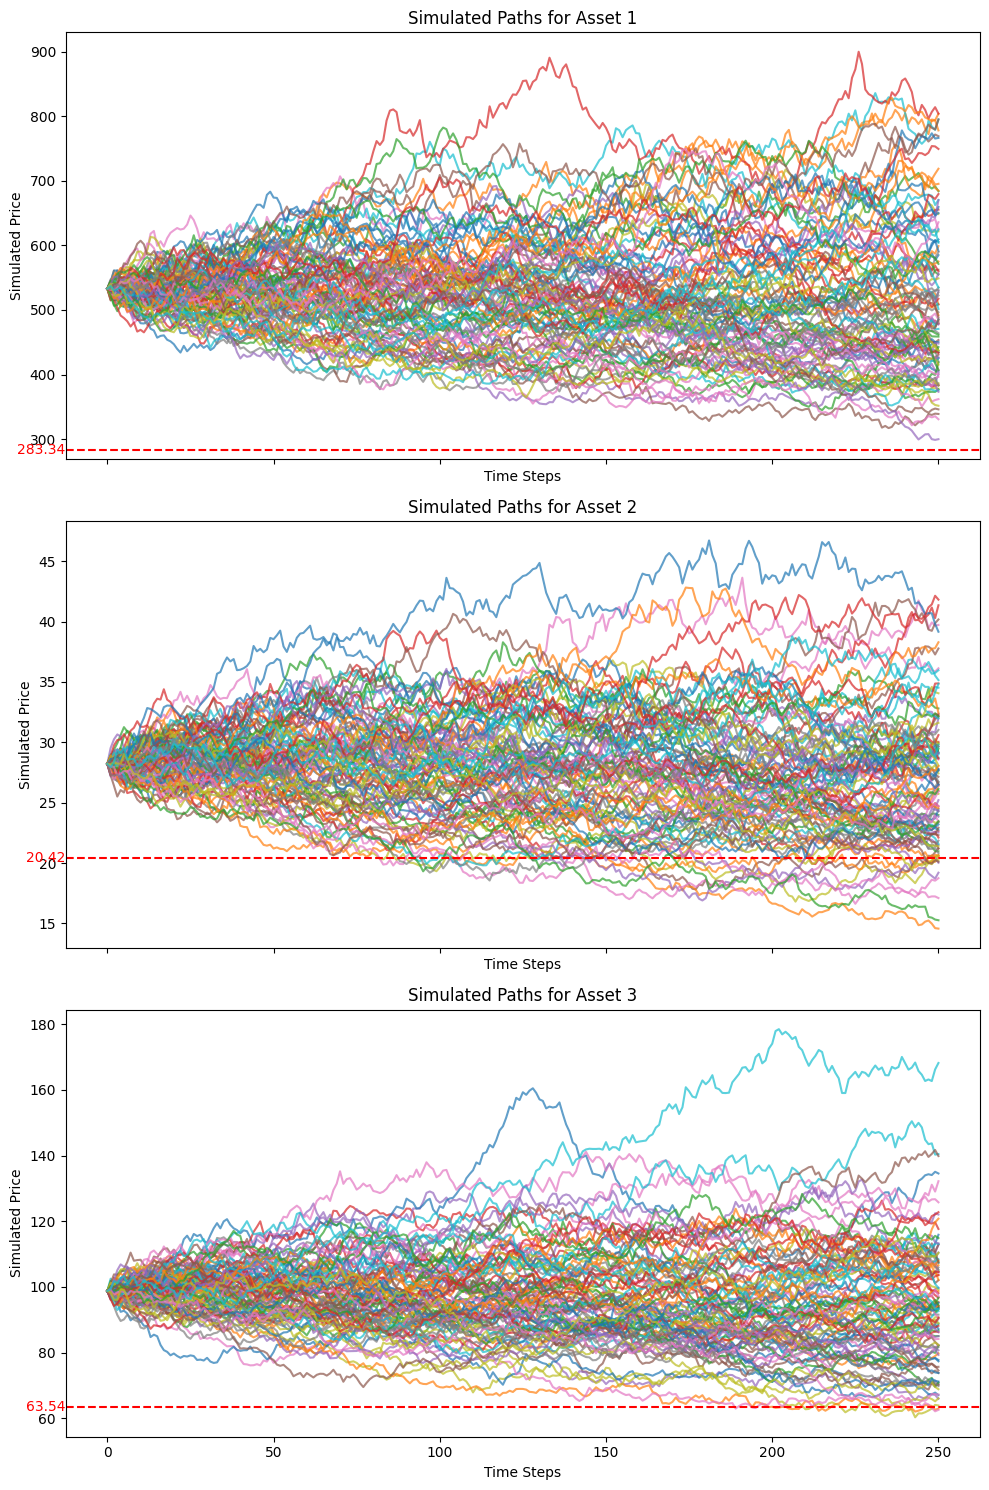

In [1]:
from GBM import MultiBS
import numpy as np

multi_bs = MultiBS()

forward_simulation = multi_bs.simulate_multi_GBM_antithetic(T=1, M=10_000)
v, sigma = multi_bs.calibrate_model(forward_simulation)
simul = multi_bs.simulate_multi_GBM_exact(T=1, M=100)
multi_bs.plot(simul)

In [2]:
import pandas as pd
start_date="2023-08-23"

start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

# Slice the historical data from start_date onwards
historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index:].values
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index:].values
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index:].values
historical_prices = np.column_stack([historical_prices_1, historical_prices_2, historical_prices_3])
historical_prices[0, :]

array([480.22924805,  34.61804962, 107.69082642])

In [26]:
historical_prices

array([[480.22924805,  34.61804962, 107.69082642],
       [478.91442871,  34.14589691, 105.90080261],
       [479.91522217,  34.35364914, 106.6361618 ],
       [482.03460693,  34.19311142, 105.39766693],
       [483.55541992,  34.13645935, 106.42328644],
       [482.27987671,  33.900383  , 106.6361618 ],
       [467.61123657,  33.40934372, 105.44604492],
       [467.27758789,  33.7870636 , 106.2781601 ],
       [471.76159668,  33.40934372, 104.02371216],
       [467.96444702,  32.45560074, 103.03679657],
       [475.68637085,  32.3706131 , 104.43977356],
       [473.55874634,  32.34228516, 105.51378632],
       [472.18963623,  32.0495491 , 105.07837677],
       [472.70181274,  32.24785233, 105.48474884],
       [472.6427002 ,  32.18175125, 104.3139801 ],
       [476.34631348,  32.24785233, 105.44402313],
       [479.39978027,  32.17230988, 104.74262238],
       [478.76937866,  31.76626205, 105.03488159],
       [473.45043945,  32.09676361, 104.58675385],
       [484.74838257,  31.74737

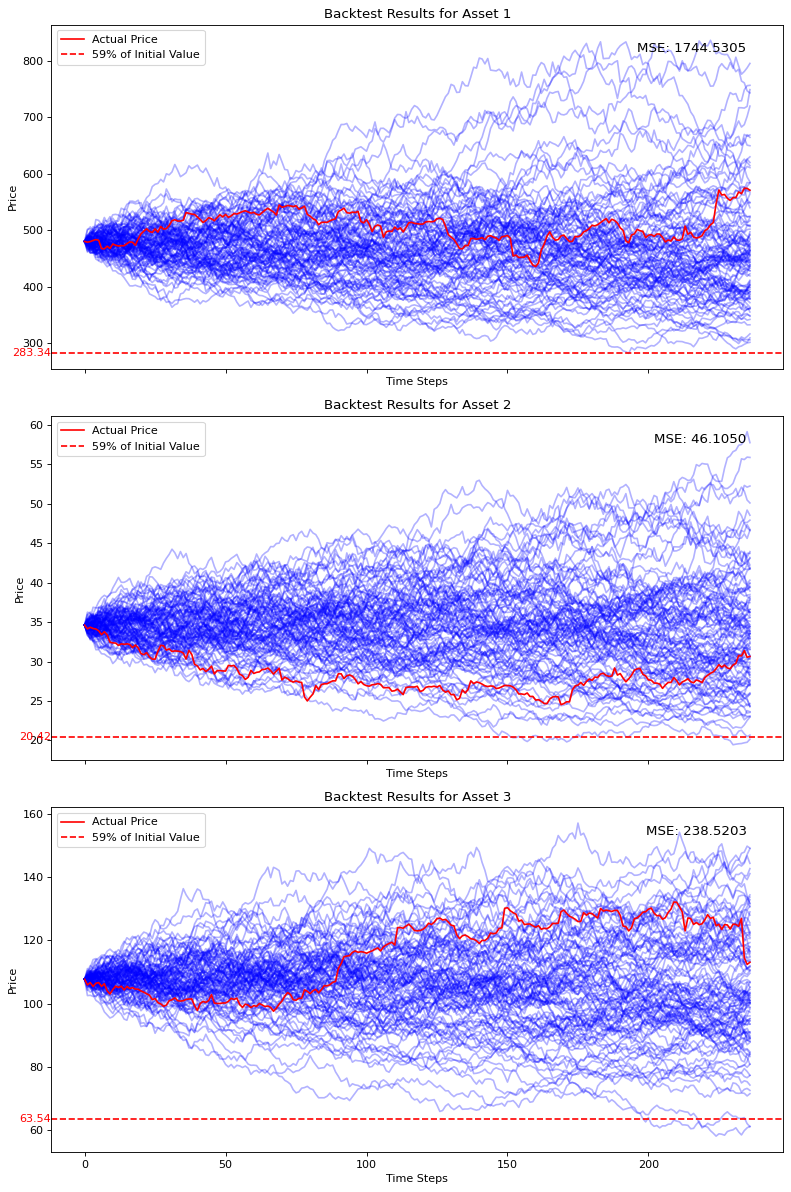

Mean Squared Error (MSE) for each asset: [1744.53045218   46.10503373  238.52027983]
Root Mean Squared Error (RMSE) for each asset: [41.76757657  6.79006876 15.44410178]


array([1744.53045218,   46.10503373,  238.52027983])

In [3]:
multi_bs.backtest(M=100)

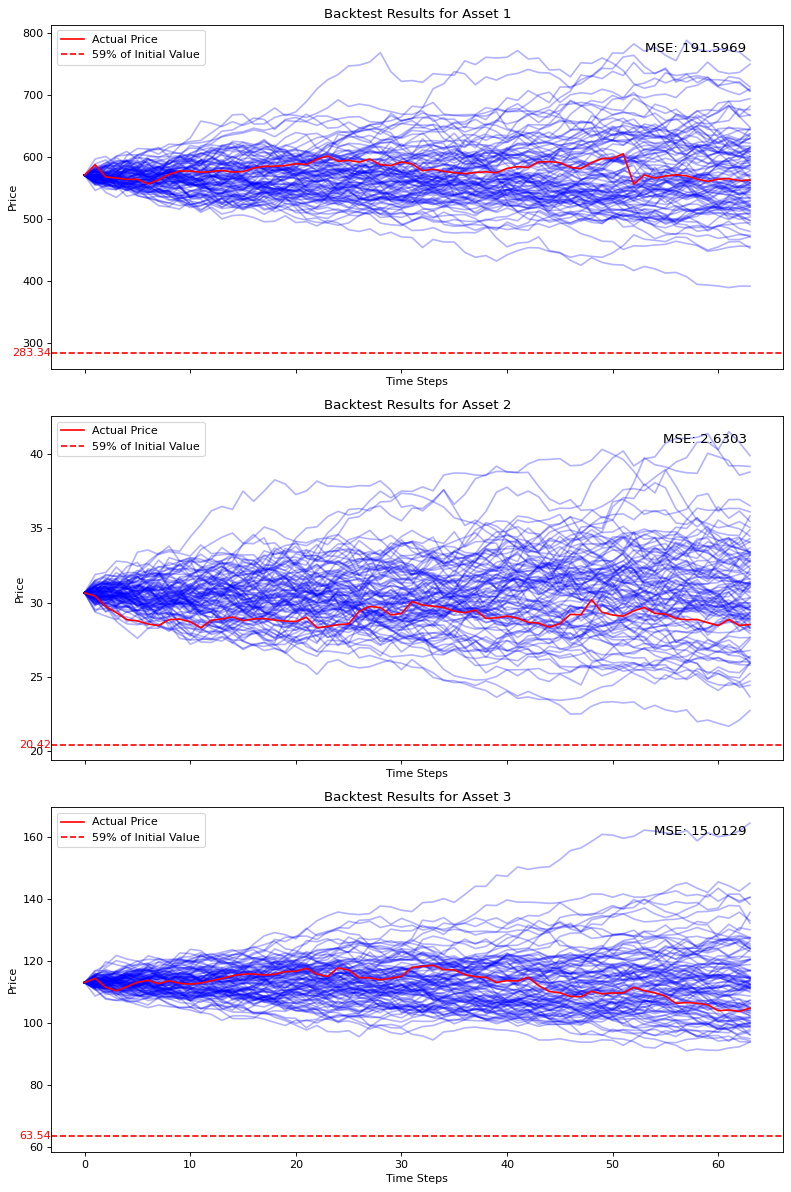

Mean Squared Error (MSE) for each asset: [191.59691286   2.63033673  15.01291516]
Root Mean Squared Error (RMSE) for each asset: [13.84185366  1.62183129  3.87465033]


array([191.59691286,   2.63033673,  15.01291516])

In [4]:
multi_bs.backtest(M=100, start_date="2024-08-01", end_date="2024-10-30")

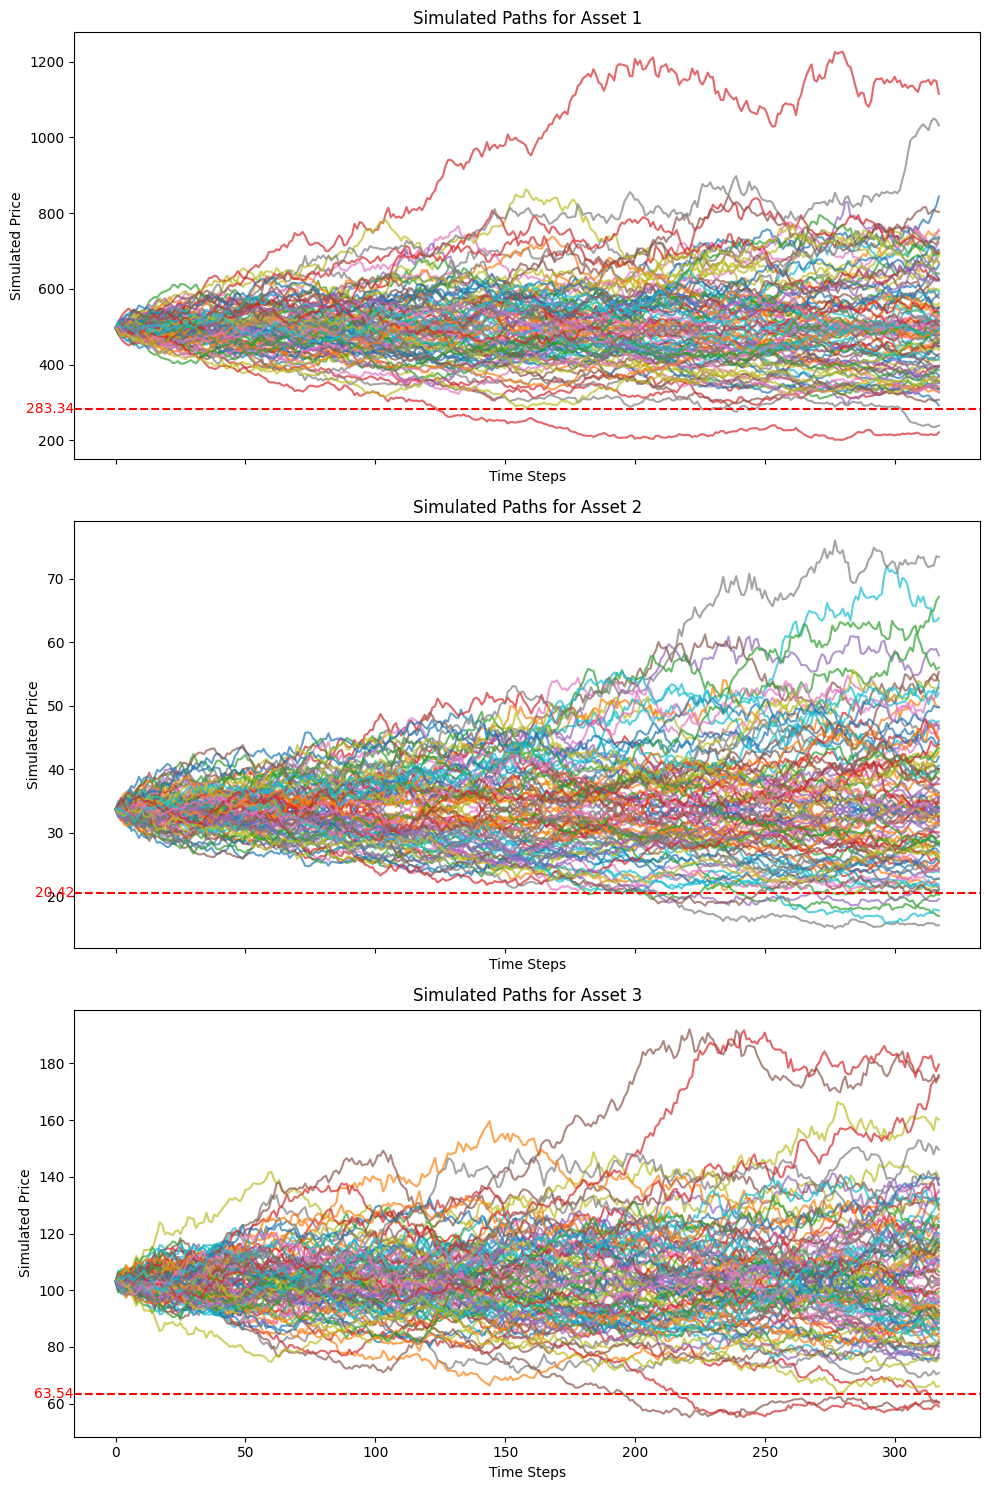

In [5]:
simul = multi_bs.simulate_multi_GBM_antithetic(T=317/250, M=100)
multi_bs.plot(simul)

In [6]:
start_date="2023-08-23"
start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index]
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index]
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index]
S0 = np.array([historical_prices_1, historical_prices_2, historical_prices_3])
print(S0)

[480.22924805  34.61804962 107.69082642]


In [7]:
from payoff import CallablePayoff
from tqdm import tqdm

payoff = CallablePayoff(0, r=0.0419, S0=S0)

epochs = 100
with tqdm(total=epochs, desc="Training Progress") as pbar:
    for epoch in range(epochs):
        path = multi_bs.simulate_multi_GBM_antithetic(T=317*multi_bs.dt, M=1_000,S0=S0) # 317 business days from initial fixing to final fixing
        path = np.log(path) # in asset, timestep, path
        # (path #, asset #, timestep #)
        path = path.transpose(2, 0, 1)
        losses = payoff.minimise_over_path(path)
        pbar.set_postfix({'Worst loss': max(losses), 
                            'Best Loss': min(losses)})
        pbar.update(1)

path = multi_bs.simulate_multi_GBM_antithetic(T=317*multi_bs.dt, M=10_000,S0=S0)
path = np.log(path) 
path = path.transpose(2, 0, 1)
x = payoff.evaluate_payoff(path, True)
print(x)

Training Progress: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s, Worst loss=4.24e+3, Best Loss=4.21e+3]


tensor([[958.3982],
        [958.3982],
        [958.3982],
        ...,
        [958.3982],
        [958.3982],
        [958.3982]])


In [8]:
x.mean()

tensor(931.6405)

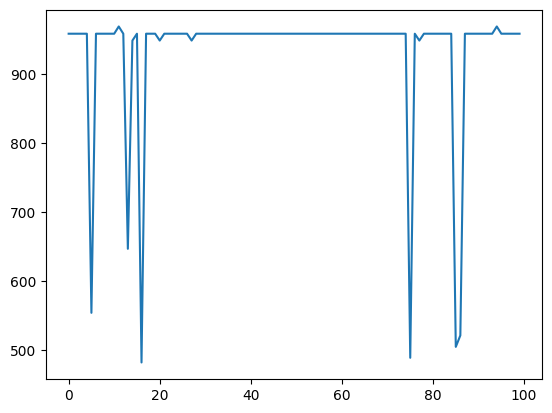

In [9]:
import matplotlib.pyplot as plt
plt.plot(x[:100])

In [10]:
x = payoff.evaluate_payoff(path, False)
print(x)
print(x.mean())

tensor([[1072.4437],
        [1072.4437],
        [ 700.7917],
        ...,
        [1072.4437],
        [1072.4437],
        [1072.4437]])
tensor(1029.4627)


In [34]:
historical_prices[:1,:]

array([[480.22924805,  34.61804962, 107.69082642]])

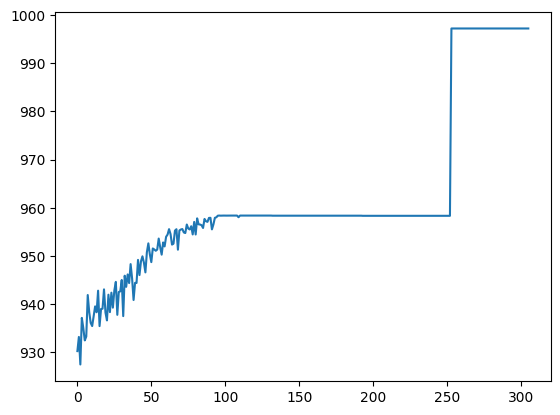

In [40]:
payout = []
payoff.current_date = 0
t = 0
for j in range(317, 317 - len(historical_prices), -1):
    t += 1
    historical_data = np.expand_dims(historical_prices[:t,], axis=0).repeat(1000, axis=0).transpose(2,1,0)
    payoff.current_date += 1
    path = multi_bs.simulate_multi_GBM_antithetic(T=j*multi_bs.dt, M=1_000,S0=S0)
    path = np.concatenate([historical_data, path], axis=1)
    path = np.log(path) 
    path = path.transpose(2, 0, 1)
    expected_payoff = payoff.evaluate_payoff(path, True).mean()
    payout.append(expected_payoff.item())

plt.plot(payout)

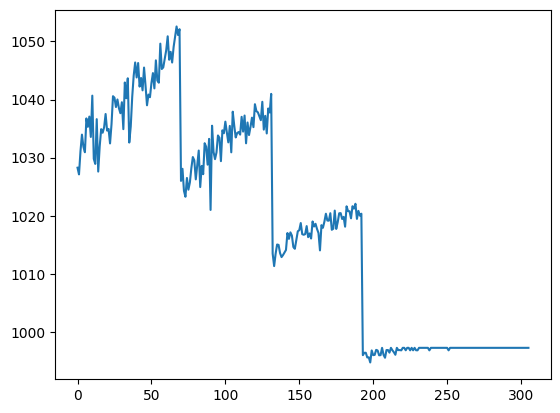

In [39]:
payout = []
payoff.current_date = 0
t = 0
for j in range(317, 317 - len(historical_prices), -1):
    t += 1
    historical_data = np.expand_dims(historical_prices[:t,], axis=0).repeat(1000, axis=0).transpose(2,1,0)
    payoff.current_date += 1
    path = multi_bs.simulate_multi_GBM_antithetic(T=j*multi_bs.dt, M=1_000,S0=S0)
    path = np.concatenate([historical_data, path], axis=1)
    path = np.log(path) 
    path = path.transpose(2, 0, 1)
    expected_payoff = payoff.evaluate_payoff(path, False).mean()
    payout.append(expected_payoff.item())

plt.plot(payout)

In [12]:
delta = multi_bs.calculate_delta(pay_off=payoff, T=317*multi_bs.dt, h=0.01, S0=S0)
print(delta)

[ 0.64022216  5.78088869 -0.59289573]


In [16]:
gamma = multi_bs.calculate_gamma(pay_off=payoff, T=317*multi_bs.dt, h=0.01, S0=S0)

In [17]:
print(f"Delta: {delta}, \nGamma: \n{gamma}")

Delta: [ 0.64022216  5.78088869 -0.59289573], 
Gamma: 
[[-1.31483397e-02  1.06360112e-03  5.82265400e-02]
 [-3.48502151e-01 -5.25315238e+00 -4.95467719e-01]
 [ 4.19963715e-02  9.50942477e-01 -5.25429457e-01]]


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Generate log-spaced values for h between 0.001 and 0.05
h_values = np.logspace(-3, -1, num=100)  # 5 values from 0.001 to approximately 0.05
T = 317 * multi_bs.dt
M = 1000
deltas = []
gammas = []

# Calculate Delta and Gamma for each h value
for h in h_values:
    delta = multi_bs.calculate_delta(payoff, T, M, h, S0)
    gamma = multi_bs.calculate_gamma(payoff, T, M, h, S0)
    deltas.append(delta)
    gammas.append(gamma)

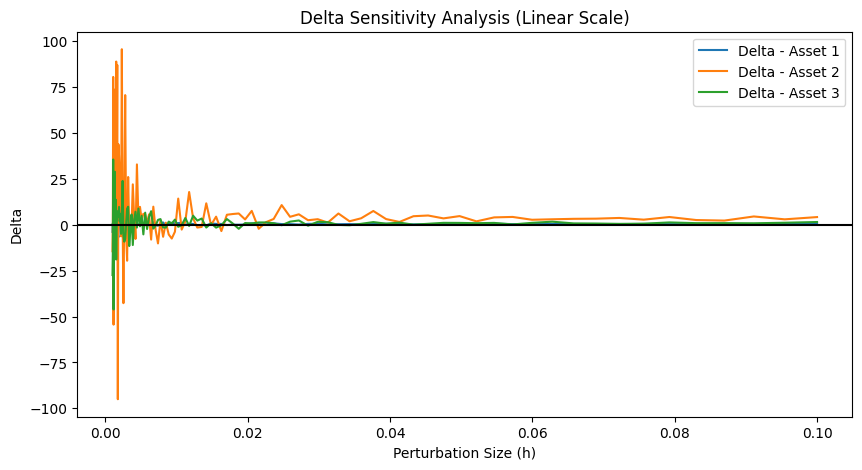

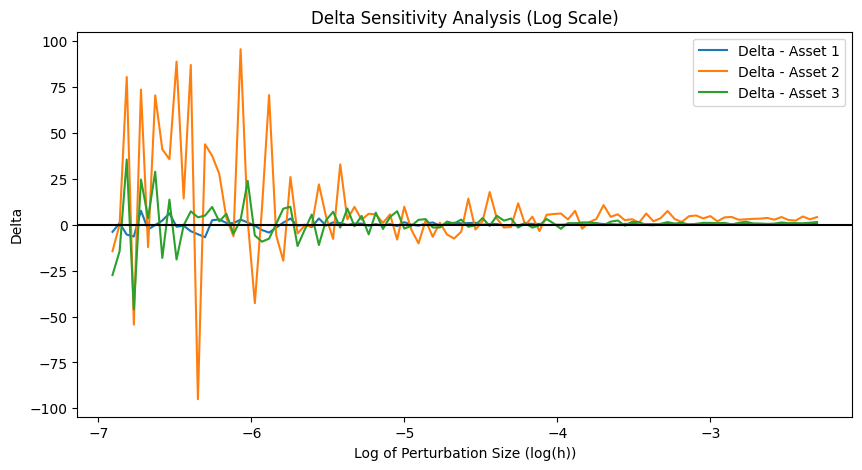

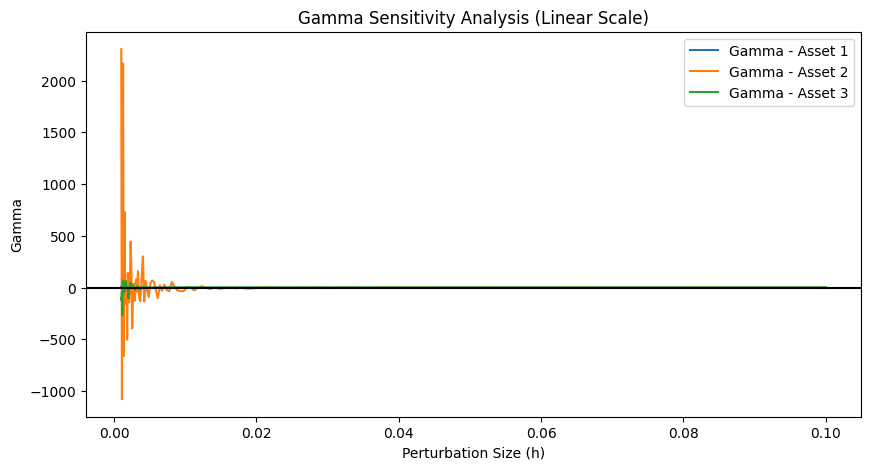

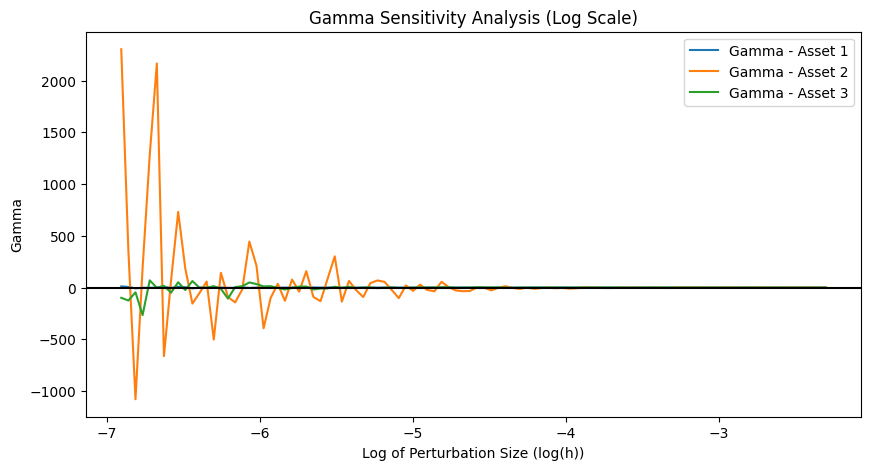

In [20]:
# Plot Delta in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")

plt.xlabel("Perturbation Size (h)")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Delta in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Perturbation Size (h)")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

In [44]:
import numpy as np
from scipy.stats import expon
from scipy.special import gamma
from scipy.optimize import minimize_scalar

# GED parameters
xi = 1.477
sigma_hat = 0.2167
v_hat = -0.0505
dt = 1 / 250
lambda_param = ((2**(-2/xi) * gamma(1/xi)) / gamma(3/xi))**0.5

# Define the GED PDF
def ged_pdf(y, xi, lambda_param):
    return (xi * np.exp(-0.5 * np.abs(y / lambda_param)**xi)) / (lambda_param * 2**(1 + 1/xi) * gamma(1/xi))

# Define the ratio function R(y)
def ratio_function(y, xi, lambda_param):
    ged_density = ged_pdf(y, xi, lambda_param)
    proposal_density = np.exp(y)  # Laplace proposal density (as part of the ratio)
    return 2 * ged_density * proposal_density

# Find the maximum of the ratio function numerically
result = minimize_scalar(lambda y: -ratio_function(y, xi, lambda_param), bounds=(-10, 10), method='bounded')

# Determine the upper bound a
a = -result.fun
print(f"Upper bound a: {a:.4f}")

Upper bound a: 1.1983


In [48]:
# Define the GED parameters
xi = 1.477
lambda_param = ((2**(-2/xi) * gamma(1/xi)) / gamma(3/xi))**0.5

# Define the GED PDF function
def ged_pdf(y, xi, lambda_param):
    return (xi * np.exp(-0.5 * np.abs(y / lambda_param)**xi)) / (lambda_param * 2**(1 + 1/xi) * gamma(1/xi))

# Define the ratio function R(y)
def ratio_function(y, xi, lambda_param):
    ged_density = ged_pdf(y, xi, lambda_param)
    proposal_density = np.exp(y)
    return 2 * ged_density * proposal_density

# Define the grid for y values
y_values = np.linspace(-5, 5, 10000)  # 10,000 points between -10 and 10

# Evaluate the ratio function at each point in the grid
ratio_values = np.array([ratio_function(y, xi, lambda_param) for y in y_values])

# Determine the upper bound a
a = np.max(ratio_values)
max_y = y_values[np.argmax(ratio_values)]

print(f"Numerically determined upper bound a: {a:.4f}")
print(f"Maximum occurs at y = {max_y:.4f}")


Numerically determined upper bound a: 1.1983
Maximum occurs at y = 0.6766


In [45]:
n_paths = 1000
n_samples = 5000

# Acceptance-rejection sampling for GED
def sample_ged(xi, lambda_param, n_samples):
    samples = []
    # Upper bound, determined numerically

    while len(samples) < n_samples:
        Y = expon.rvs()  # Generate from Exp(1)
        U = np.random.uniform(0, 1)
        # Calculate GED density ratio
        ged_pdf = (xi * np.exp(-0.5 * np.abs(Y / lambda_param)**xi)) / (lambda_param * 2**(1 + 1/xi) * gamma(1/xi))
        ratio = 2 * ged_pdf * np.exp(Y) / a
        # Accept or reject
        if U <= ratio:
            V = np.random.uniform(0, 1)
            Z = -Y if V < 0.5 else Y
            samples.append(Z)
    
    return np.array(samples)

Z_samples = sample_ged(xi, lambda_param, n_samples)

# Aggregate 5-day log-returns
aggregated_returns = []
for j in range(n_paths):
    Z_j_prime = np.sum(Z_samples[5*j:5*(j+1)])
    R_j = Z_j_prime * sigma_hat * np.sqrt(5 * dt) + 5 * v_hat * dt
    aggregated_returns.append(R_j)

# Sort the returns
sorted_returns = np.sort(aggregated_returns)

# Calculate 5-day VaR at 99% confidence level
VaR_5_day = -sorted_returns[int(0.01 * n_paths)]
print(f"5-day VaR at 99% confidence level: {VaR_5_day:.4f}")

5-day VaR at 99% confidence level: 0.1530


In [46]:
n_paths = 1000
n_samples = 1000

# Acceptance-rejection sampling for GED
def sample_ged(xi, lambda_param, n_samples):
    samples = []
    # Upper bound, determined numerically

    while len(samples) < n_samples:
        Y = expon.rvs()  # Generate from Exp(1)
        U = np.random.uniform(0, 1)
        # Calculate GED density ratio
        ged_pdf = (xi * np.exp(-0.5 * np.abs(Y / lambda_param)**xi)) / (lambda_param * 2**(1 + 1/xi) * gamma(1/xi))
        ratio = 2 * ged_pdf * np.exp(Y) / a
        # Accept or reject
        if U <= ratio:
            V = np.random.uniform(0, 1)
            Z = -Y if V < 0.5 else Y
            samples.append(Z)
    
    return np.array(samples)

Z_samples = sample_ged(xi, lambda_param, n_samples)

aggregated_returns = []
for j in range(n_paths):
    R_j = Z_samples[j] * sigma_hat * np.sqrt(5 * dt) + 5 * v_hat * dt
    aggregated_returns.append(R_j)

# Sort the returns
sorted_returns = np.sort(aggregated_returns)

# Calculate 5-day VaR at 99% confidence level
VaR_1_day = -sorted_returns[int(0.01 * n_paths)]
print(f"1-day VaR at 99% confidence level: {VaR_1_day:.4f}")

1-day VaR at 99% confidence level: 0.0748
